### Feature Engineering & Extraction der maritimen Features

In [2]:
import sys
sys.path = ["", ".."] + sys.path[1:]

In [9]:
import pathlib
import pandas as pd
import numpy as np
import joblib
import aisfeel
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd

Local

In [11]:
data = pathlib.Path("data")
cargo_tanker = pathlib.Path("d:/Datasets/cargo_tanker/")
cleaned_set = joblib.load(data / "cargo_tanker_wetter_cleaned.joblib")

cleaned_set

FileNotFoundError: [Errno 2] No such file or directory: 'data/cargo_tanker_wetter_cleaned.joblib'

In [5]:
cleaned_set.columns

Index(['latitude', 'longitude', 'navigational_status', 'rot', 'sog', 'cog',
       'heading', 'ship_type', 'cargo_type', 'width', 'length', 'draught',
       'eta', 'a', 'b', 'c', 'd', 'h3_res_5',
       'sea_surface_wind_wave_significant_height_unit_m',
       'sea_surface_secondary_swell_wave_from_direction_unit_degree',
       'sea_surface_wave_from_direction_unit_degree',
       'sea_surface_primary_swell_wave_from_direction_unit_degree',
       'sea_surface_wave_mean_period_from_variance_spectral_density_inverse_frequency_moment_unit_s',
       'sea_surface_wave_from_direction_at_variance_spectral_density_maximum_unit_degree',
       'sea_surface_wave_period_at_variance_spectral_density_maximum_unit_s',
       'sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment_unit_s',
       'sea_surface_primary_swell_wave_significant_height_unit_m',
       'sea_surface_wind_wave_from_direction_unit_degree',
       'sea_surface_secondary_swell_wave_mean_period_un

In [6]:
cleaned_set.dtypes

latitude                                                                                              float64
longitude                                                                                             float64
navigational_status                                                                                    object
rot                                                                                                   float64
sog                                                                                                   float64
cog                                                                                                   float64
heading                                                                                               float64
ship_type                                                                                              object
cargo_type                                                                                             object
width     

Filtern der Daten: 1. <5 Knoten SOG, 2. Default Outlier Werte, 3. Navstatus moored und anchored 4. Missing data, Wind und Strömungsgeschwindigkeit werden in Richtungswinkel und Kraft umgerechnet: Speed=|V| = π /180 × √ u2 + v2, Richtung= θ = 180 + 180 /π atan2(u, v).
Berechnung Durchschnittsgeschwindigkeit, Labeling "Vessel is sailing"/"Vessel has stopped"
Trajectory generation aus den AIS-Daten; Filtern der Daten: 1. Fehlende IMO,MMSI,DWT,speed,course 2. Falsche MMSI (nicht 9 stellige nummer), 3. Duplikate
1. Datenfusion basierend auf timestamps: Tweets oder Beschreibende Statements mit AIS Koordinaten die Zeitlich am nähesten sind. 2. manuelles Labeln von Rettungs Trajektorien
Lade- und Entladehafen abschätzung über draft info aus AIS Draft +-20% max change of draft at each stopping point -> be-/entladung; 1. Interpolate missing speed and draft with value immediatley before 2. generate Geohash(4) and Geohash(7); 3. staying points: vessel in same Geohash 4 >5h ->  extract staying start and endtime 4. Most counted draft during staying -> before-arrival draft -> associate Geohash 7 mit längster staying period mit berthing/mooring point & assume draft of next staying point (Geohash 4 as post starting draft 5. Export/Import Berth based on pre-arrival and post-starting draft
1. Umwandlung von COG(C)  und Speed(v) in Bewegungsvektoren (Vx,Vy): Vx=cos(m)*v, Vy=sin(m)*v mit m = {90-C (0<=C<90), 90+C (90<=C<180), 270-C (180<=C<270), 270+C (270<=C<360) 2. Interpolation der Position mit den Bewegunsvektoren 3. Schiffskateorien 4. Längen normalisierung (schifflänge/länge des längsten schiffs)
Berechnung des  Energy Efficiency Operational Indicator (EEOI); Motorkraft berechnung mittels annäherungsformel; Korrektion des Speed wertes um die Strömungsgeschwindigkeit (V = Wurzel((uship-ucurrent)^2+(vship-vcurrent)^2)
Codierung der Windrichtung
Fusion der Datenquellen zu einem Datensatz, Filtern der Sensorfehler, Normalisierung 
Mittels k-NN(1-NN) den nächsten Hafen zu jedem AIS Port bestimmen
Four-Hot Encoding (lon,lat,sog,cog) -> geometrie von Zeit Dimension trennen -> 4 One-Hot Vektor concatenated -> Auflösung der Werte lat,lon: 0.01° (ca 1km), sog: 1 Knoten, cog: 5°, Voyages: Split falls 4h zwischen 2 aufeinanderfolgenden AIS Nachrichten, Lange voyages in kleinere 4-24h; Resampling auf 10 mins
Windowing der Daten
Berechnung der Kosten pro Schiff
Anwendung verschiedener Bild-Filter: Blur,grayscale,contrast,brightness
drift: differenz heading und cog; leeway
"Berechnung von: Acceleration, DayOfWeek, HourOfDay, CourseChangeRate, HeadingChangeRate,
NumCloseInteractions, NumLocalInteractions, ClosestType, ClosestSpeed, ClosestCourse, ClosestDistance, SinceDawn, SinceDusk
3rd Tier Lat-t2, Lon-t2, Course-t2, Heading-t2, Speed-t2, Acceleration-t2"

Filtern der Daten: 1. <5 Knoten SOG, 2. Default Outlier Werte, 3. Navstatus moored und anchored 4. Missing data  


Trajectory generation aus den AIS-Daten; Filtern der Daten: 1. Fehlende IMO,MMSI,DWT,speed,course 2. Falsche MMSI (nicht 9 stellige nummer), 3. Duplikate


1. Datenfusion basierend auf timestamps: Tweets oder Beschreibende Statements mit AIS Koordinaten die Zeitlich am nähesten sind. 2. manuelles Labeln von Rettungs Trajektorien

Umwandlung von SOG und COG in Bewegungsvektoren, Interpolation mit Lat Lon für Position, Gruppierung der Schiffstypen in 3 Kategorien (Tanker, cargo, other), Normalisierte Schiffslänge [0,1]
Engine Power annäherung, Cargo Masse berechnung


Codierung der Windrichtung
Fusion der Datenquellen zu einem Datensatz, Filtern der Sensorfehler, Normalisierung 

Filtern von SOG Werten >30 Knoten, Positionen; Voyages: Split falls 4h zwischen 2 aufeinanderfolgenden AIS Nachrichten, Lange voyages in kleinere 4-24h; Resampling auf 10 mins
Observer-Daten für Labeling der VMS Daten als "fishing" oder "not fishing"


Fishing Vessel identification: fishing vessel registries, vessels classified as fishing by NN of GFW, Filter: Wrong positions, nicht-Fischerei Vessel; Werte für EEA Formel aus vessel Registern und random forests, Schätzung des Treibstoffverbrauch, Länderspezifische kosten für Treibstoff, und abgeleitet aus Speed/ design speed


In [7]:
# import importlib
# importlib.reload(aisfeel)

Step 0: One Hot Encoding

In [8]:
df = cleaned_set.pipe(aisfeel.extraction.ais_calculators.ais_one_hot_encoding)

Step 1: Geometry Features
- h3 index
- movement vector sog + lat lon
- angle difference heading cog


In [9]:
set(df.columns) - set(cleaned_set.columns)

{'cargo_type_Category OS',
 'cargo_type_Category X',
 'cargo_type_Category Y',
 'cargo_type_Category Z',
 'cargo_type_No additional information',
 'cargo_type_Reserved for future use',
 'navigational_status_Constrained by her draught',
 'navigational_status_Not under command',
 'navigational_status_Restricted maneuverability',
 'navigational_status_Under way using engine',
 'ship_type_Cargo',
 'ship_type_Tanker'}

In [10]:
df = df.pipe(aisfeel.spatial_calculators.calc_hex_res)

In [11]:
set(df.columns)-set(cleaned_set.columns)

{'cargo_type_Category OS',
 'cargo_type_Category X',
 'cargo_type_Category Y',
 'cargo_type_Category Z',
 'cargo_type_No additional information',
 'cargo_type_Reserved for future use',
 'h3_res_4',
 'h3_res_6',
 'h3_res_7',
 'h3_res_8',
 'h3_res_9',
 'navigational_status_Constrained by her draught',
 'navigational_status_Not under command',
 'navigational_status_Restricted maneuverability',
 'navigational_status_Under way using engine',
 'ship_type_Cargo',
 'ship_type_Tanker'}

### Vektor darstellungen
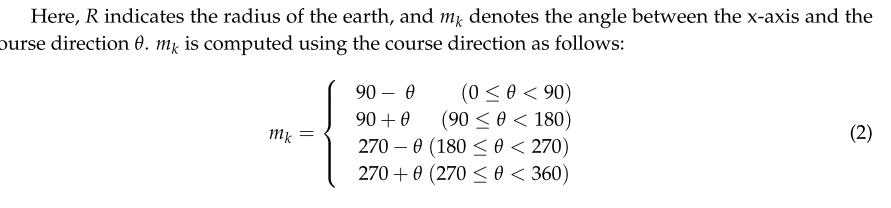

Vx = cos(mk)·v, Vy= sin(mk)·v


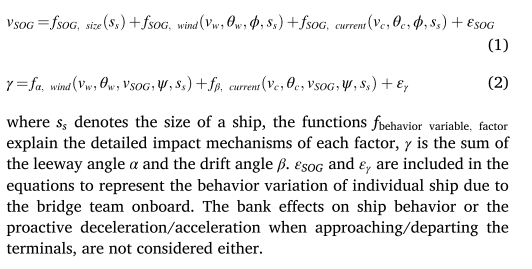



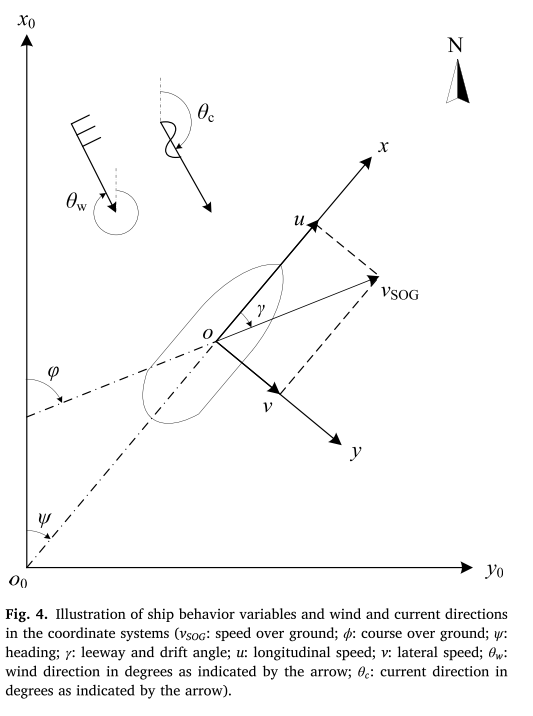

In [12]:
df.columns

Index(['latitude', 'longitude', 'rot', 'sog', 'cog', 'heading', 'width',
       'length', 'draught', 'eta', 'a', 'b', 'c', 'd', 'h3_res_5',
       'sea_surface_wind_wave_significant_height_unit_m',
       'sea_surface_secondary_swell_wave_from_direction_unit_degree',
       'sea_surface_wave_from_direction_unit_degree',
       'sea_surface_primary_swell_wave_from_direction_unit_degree',
       'sea_surface_wave_mean_period_from_variance_spectral_density_inverse_frequency_moment_unit_s',
       'sea_surface_wave_from_direction_at_variance_spectral_density_maximum_unit_degree',
       'sea_surface_wave_period_at_variance_spectral_density_maximum_unit_s',
       'sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment_unit_s',
       'sea_surface_primary_swell_wave_significant_height_unit_m',
       'sea_surface_wind_wave_from_direction_unit_degree',
       'sea_surface_secondary_swell_wave_mean_period_unit_s',
       'sea_surface_wave_stokes_drift_x_velocity_u

In [13]:
def calc_m(cog):
    if (0 <= cog < 90):
        return 90 - cog
    if (90<= cog <= 180):
        return 90 + cog
    if (180 <= cog < 270):
        return 270 - cog
    if (270 <= cog < 360):
        return 270 + cog

vect_calc_m = np.vectorize(calc_m)

def angle_to_vec(df):
    cog = df.cog.values
    m = vect_calc_m(cog)
    v = df.sog.values
    vx = np.cos(m)*v
    vy = np.sin(m)*v
    df["cog_vx"] = vx
    df["cog_vy"] = vy
    return df

def drift_angle(df):
    df["drift_angle"] = df.heading - df.cog
    return df

def u_v_ship(df):
    heading = df.heading.values
    V = df.sog.values
    u_ship = V * np.sin(heading)
    v_ship = V * np.cos(heading)
    u_current = df["eastward_sea_water_velocity_unit_m s-1"]
    v_current = df["northward_sea_water_velocity_unit_m s-1"]
    df["u_ship"] = u_ship
    df["v_ship"] = v_ship
    df["current_corrected_speed"] = np.sqrt((np.square(u_ship - u_current)) + (np.square(v_ship-v_current)))
    return df

In [14]:
df = df.pipe(angle_to_vec).pipe(drift_angle).pipe(u_v_ship)

In [15]:
df

latitude  longitude  rot   sog    cog  \
timestamp           mmsi                                                
2021-01-02 00:00:01 266420000  54.497382  11.551000  0.0  12.0  296.6   
2021-01-02 00:00:04 245871000  56.823012  12.099355  0.0  10.2  164.9   
                    240597000  57.426433   8.607067  0.0  13.8   47.0   
2021-01-02 00:00:05 257787000  56.356855   3.895008  0.0   0.8  159.3   
2021-01-02 00:00:06 205743000  57.574450   9.041350 -1.1  16.0   57.4   
...                                  ...        ...  ...   ...    ...   
2021-01-02 23:59:58 257677000  57.683643   8.903580  0.0   8.2  280.4   
                    636015737  55.864397  10.877138 -0.0  14.9   41.0   
                    209210000  56.058032  12.657232  0.0  10.7  316.9   
                    230995000  55.475420   7.599495 -1.1  18.2  300.5   
                    255806262  57.678610   9.184613 -0.7  13.0  235.5   

                               heading  width  length  draught  \
timestamp           mmsi                                         
2021-01-02 00:00:01 266420000    296.0   24.0   150.0      8.3   
2021-01-02 00:00:04 245871000    161.0   13.0    95.0      6.3   
                    240597000     46.0   27.0   182.0      7.8   
2021-01-02 00:00:05 257787000     32.0   21.0    90.0      6.3   
2021-01-02 00:00:06 205743000     57.0   30.0   180.0      7.6   
...                                ...    ...     ...      ...   
2021-01-02 23:59:58 257677000    280.0   15.0   104.0      5.0   
                    636015737     41.0   26.0   160.0      9.0   
                    209210000    313.0   13.0    94.0      5.0   
                    230995000    302.0   24.0   164.0      6.0   
                    255806262    235.0   32.0   183.0     10.3   

                                              eta  ...            h3_res_6  \
timestamp           mmsi                           ...                       
2021-01-02 00:00:01 266420000 2021-02-02 18:00:00  ...  604027760851025919   
2021-01-02 00:00:04 245871000 2021-01-02 10:00:00  ...  604030030875459583   
                    240597000 2021-04-02 23:00:00  ...  603650792645197823   
2021-01-02 00:00:05 257787000 2022-01-29 11:30:00  ...  603929031229833215   
2021-01-02 00:00:06 205743000 2021-01-02 08:00:00  ...  604030233946882047   
...                                           ...  ...                 ...   
2021-01-02 23:59:58 257677000 2021-01-02 20:00:00  ...  604030238241849343   
                    636015737 2021-03-02 11:00:00  ...  604030054363561983   
                    209210000 2021-02-02 10:00:00  ...  604030123351474175   
                    230995000 2021-02-02 14:00:00  ...  604031368086683647   
                    255806262 2021-05-02 12:00:00  ...  604030239315591167   

                                         h3_res_7            h3_res_8  \
timestamp           mmsi                                                
2021-01-02 00:00:01 266420000  608531360411287551  613034960026075135   
2021-01-02 00:00:04 245871000  608533630486052863  613037230105034751   
                    240597000  608154392155127807  612657991774109695   
2021-01-02 00:00:05 257787000  608432630739763199  612936230354550783   
2021-01-02 00:00:06 205743000  608533833523920895  613037433142902783   
...                                           ...                 ...   
2021-01-02 23:59:58 257677000  608155161122045951  612658760738930687   
                    636015737  608533653638610943  613037253255495679   
                    209210000  608533722962067455  613037322578952191   
                    230995000  608534967697276927  613038567322550271   
                    255806262  608533838875852799  613037438496931839   

                                         h3_res_9     cog_vx     cog_vy  \
timestamp           mmsi                                                  
2021-01-02 00:00:01 266420000  617538559652397055   5.300199  10.766053   
2021-01-02 00:00:04 245871000  61

In [16]:
set(df.columns)-set(cleaned_set.columns)

{'cargo_type_Category OS',
 'cargo_type_Category X',
 'cargo_type_Category Y',
 'cargo_type_Category Z',
 'cargo_type_No additional information',
 'cargo_type_Reserved for future use',
 'cog_vx',
 'cog_vy',
 'current_corrected_speed',
 'drift_angle',
 'h3_res_4',
 'h3_res_6',
 'h3_res_7',
 'h3_res_8',
 'h3_res_9',
 'navigational_status_Constrained by her draught',
 'navigational_status_Not under command',
 'navigational_status_Restricted maneuverability',
 'navigational_status_Under way using engine',
 'ship_type_Cargo',
 'ship_type_Tanker',
 'u_ship',
 'v_ship'}

In [17]:
df.pipe(drift_angle)

latitude  longitude  rot   sog    cog  \
timestamp           mmsi                                                
2021-01-02 00:00:01 266420000  54.497382  11.551000  0.0  12.0  296.6   
2021-01-02 00:00:04 245871000  56.823012  12.099355  0.0  10.2  164.9   
                    240597000  57.426433   8.607067  0.0  13.8   47.0   
2021-01-02 00:00:05 257787000  56.356855   3.895008  0.0   0.8  159.3   
2021-01-02 00:00:06 205743000  57.574450   9.041350 -1.1  16.0   57.4   
...                                  ...        ...  ...   ...    ...   
2021-01-02 23:59:58 257677000  57.683643   8.903580  0.0   8.2  280.4   
                    636015737  55.864397  10.877138 -0.0  14.9   41.0   
                    209210000  56.058032  12.657232  0.0  10.7  316.9   
                    230995000  55.475420   7.599495 -1.1  18.2  300.5   
                    255806262  57.678610   9.184613 -0.7  13.0  235.5   

                               heading  width  length  draught  \
timestamp           mmsi                                         
2021-01-02 00:00:01 266420000    296.0   24.0   150.0      8.3   
2021-01-02 00:00:04 245871000    161.0   13.0    95.0      6.3   
                    240597000     46.0   27.0   182.0      7.8   
2021-01-02 00:00:05 257787000     32.0   21.0    90.0      6.3   
2021-01-02 00:00:06 205743000     57.0   30.0   180.0      7.6   
...                                ...    ...     ...      ...   
2021-01-02 23:59:58 257677000    280.0   15.0   104.0      5.0   
                    636015737     41.0   26.0   160.0      9.0   
                    209210000    313.0   13.0    94.0      5.0   
                    230995000    302.0   24.0   164.0      6.0   
                    255806262    235.0   32.0   183.0     10.3   

                                              eta  ...            h3_res_6  \
timestamp           mmsi                           ...                       
2021-01-02 00:00:01 266420000 2021-02-02 18:00:00  ...  604027760851025919   
2021-01-02 00:00:04 245871000 2021-01-02 10:00:00  ...  604030030875459583   
                    240597000 2021-04-02 23:00:00  ...  603650792645197823   
2021-01-02 00:00:05 257787000 2022-01-29 11:30:00  ...  603929031229833215   
2021-01-02 00:00:06 205743000 2021-01-02 08:00:00  ...  604030233946882047   
...                                           ...  ...                 ...   
2021-01-02 23:59:58 257677000 2021-01-02 20:00:00  ...  604030238241849343   
                    636015737 2021-03-02 11:00:00  ...  604030054363561983   
                    209210000 2021-02-02 10:00:00  ...  604030123351474175   
                    230995000 2021-02-02 14:00:00  ...  604031368086683647   
                    255806262 2021-05-02 12:00:00  ...  604030239315591167   

                                         h3_res_7            h3_res_8  \
timestamp           mmsi                                                
2021-01-02 00:00:01 266420000  608531360411287551  613034960026075135   
2021-01-02 00:00:04 245871000  608533630486052863  613037230105034751   
                    240597000  608154392155127807  612657991774109695   
2021-01-02 00:00:05 257787000  608432630739763199  612936230354550783   
2021-01-02 00:00:06 205743000  608533833523920895  613037433142902783   
...                                           ...                 ...   
2021-01-02 23:59:58 257677000  608155161122045951  612658760738930687   
                    636015737  608533653638610943  613037253255495679   
                    209210000  608533722962067455  613037322578952191   
                    230995000  608534967697276927  613038567322550271   
                    255806262  608533838875852799  613037438496931839   

                                         h3_res_9     cog_vx     cog_vy  \
timestamp           mmsi                                                  
2021-01-02 00:00:01 266420000  617538559652397055   5.300199  10.766053   
2021-01-02 00:00:04 245871000  61

In [18]:
set(df.columns)-set(cleaned_set.columns)

{'cargo_type_Category OS',
 'cargo_type_Category X',
 'cargo_type_Category Y',
 'cargo_type_Category Z',
 'cargo_type_No additional information',
 'cargo_type_Reserved for future use',
 'cog_vx',
 'cog_vy',
 'current_corrected_speed',
 'drift_angle',
 'h3_res_4',
 'h3_res_6',
 'h3_res_7',
 'h3_res_8',
 'h3_res_9',
 'navigational_status_Constrained by her draught',
 'navigational_status_Not under command',
 'navigational_status_Restricted maneuverability',
 'navigational_status_Under way using engine',
 'ship_type_Cargo',
 'ship_type_Tanker',
 'u_ship',
 'v_ship'}

In [19]:
def _is_sailing(sog, threshold=3):
    """
    max Loitering threshold defined as vessel moving under 5kt (Cazzanti und Pallotta 2015)
    https://globalfishingwatch.org/faqs/what-are-loitering-events-in-the-carrier-vessel-portal/ -> uses average of 2kt
    Prameters
    sog: sog values of vessel
    threshold: threshold below which vessel is considered as not sailing
    """
    if sog < threshold:
        return 0
    else:
        return 1

def is_sailing(df):
    vect_is_sailing = np.vectorize(_is_sailing)
    df["is_sailing"] = vect_is_sailing(df.sog.values)
    return df


In [20]:
df.pipe(is_sailing)

latitude  longitude  rot   sog    cog  \
timestamp           mmsi                                                
2021-01-02 00:00:01 266420000  54.497382  11.551000  0.0  12.0  296.6   
2021-01-02 00:00:04 245871000  56.823012  12.099355  0.0  10.2  164.9   
                    240597000  57.426433   8.607067  0.0  13.8   47.0   
2021-01-02 00:00:05 257787000  56.356855   3.895008  0.0   0.8  159.3   
2021-01-02 00:00:06 205743000  57.574450   9.041350 -1.1  16.0   57.4   
...                                  ...        ...  ...   ...    ...   
2021-01-02 23:59:58 257677000  57.683643   8.903580  0.0   8.2  280.4   
                    636015737  55.864397  10.877138 -0.0  14.9   41.0   
                    209210000  56.058032  12.657232  0.0  10.7  316.9   
                    230995000  55.475420   7.599495 -1.1  18.2  300.5   
                    255806262  57.678610   9.184613 -0.7  13.0  235.5   

                               heading  width  length  draught  \
timestamp           mmsi                                         
2021-01-02 00:00:01 266420000    296.0   24.0   150.0      8.3   
2021-01-02 00:00:04 245871000    161.0   13.0    95.0      6.3   
                    240597000     46.0   27.0   182.0      7.8   
2021-01-02 00:00:05 257787000     32.0   21.0    90.0      6.3   
2021-01-02 00:00:06 205743000     57.0   30.0   180.0      7.6   
...                                ...    ...     ...      ...   
2021-01-02 23:59:58 257677000    280.0   15.0   104.0      5.0   
                    636015737     41.0   26.0   160.0      9.0   
                    209210000    313.0   13.0    94.0      5.0   
                    230995000    302.0   24.0   164.0      6.0   
                    255806262    235.0   32.0   183.0     10.3   

                                              eta  ...            h3_res_7  \
timestamp           mmsi                           ...                       
2021-01-02 00:00:01 266420000 2021-02-02 18:00:00  ...  608531360411287551   
2021-01-02 00:00:04 245871000 2021-01-02 10:00:00  ...  608533630486052863   
                    240597000 2021-04-02 23:00:00  ...  608154392155127807   
2021-01-02 00:00:05 257787000 2022-01-29 11:30:00  ...  608432630739763199   
2021-01-02 00:00:06 205743000 2021-01-02 08:00:00  ...  608533833523920895   
...                                           ...  ...                 ...   
2021-01-02 23:59:58 257677000 2021-01-02 20:00:00  ...  608155161122045951   
                    636015737 2021-03-02 11:00:00  ...  608533653638610943   
                    209210000 2021-02-02 10:00:00  ...  608533722962067455   
                    230995000 2021-02-02 14:00:00  ...  608534967697276927   
                    255806262 2021-05-02 12:00:00  ...  608533838875852799   

                                         h3_res_8            h3_res_9  \
timestamp           mmsi                                                
2021-01-02 00:00:01 266420000  613034960026075135  617538559652397055   
2021-01-02 00:00:04 245871000  613037230105034751  617540829731356671   
                    240597000  612657991774109695  617161591399907327   
2021-01-02 00:00:05 257787000  612936230354550783  617439829980872703   
2021-01-02 00:00:06 205743000  613037433142902783  617541032769486847   
...                                           ...                 ...   
2021-01-02 23:59:58 257677000  612658760738930687  617541037068910591   
                    636015737  613037253255495679  617540852882079743   
                    209210000  613037322578952191  617540922204749823   
                    230995000  613038567322550271  617542166948085759   
                    255806262  613037438496931839  617541038124040191   

                                  cog_vx     cog_vy  drift_angle     u_ship  \
timestamp           mmsi                                                      
2021-01-02 00:00:01 266420000   5.300199  10.766053         -0.6   7.641135   
2021-01-02 00:00:04 2

In [21]:
def normalize_size(df):
    lengths = df.length
    max_length = df.length.max()
    widths = df.width
    max_width = df.width.max()
    df["norm_length"] = lengths / max_length
    df["norm_width"] = widths/max_width
    return df

In [22]:
df = df.pipe(normalize_size)

In [23]:
set(df.columns)-set(cleaned_set.columns)

{'cargo_type_Category OS',
 'cargo_type_Category X',
 'cargo_type_Category Y',
 'cargo_type_Category Z',
 'cargo_type_No additional information',
 'cargo_type_Reserved for future use',
 'cog_vx',
 'cog_vy',
 'current_corrected_speed',
 'drift_angle',
 'h3_res_4',
 'h3_res_6',
 'h3_res_7',
 'h3_res_8',
 'h3_res_9',
 'is_sailing',
 'navigational_status_Constrained by her draught',
 'navigational_status_Not under command',
 'navigational_status_Restricted maneuverability',
 'navigational_status_Under way using engine',
 'norm_length',
 'norm_width',
 'ship_type_Cargo',
 'ship_type_Tanker',
 'u_ship',
 'v_ship'}

### Saving the results

In [24]:
joblib.dump(df, data / "cargo_tanker_literature_features.joblib")

['data\\cargo_tanker_literature_features.joblib']